<a href="https://colab.research.google.com/github/olga-terekhova/tdsb-calendar/blob/main/Integrate_Calendar_Template_PDF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# ------------------------
# Parameters
# ------------------------


year = 2025
month = 10
workweek = 7 # try 5 for Mon–Fri only
week_start="Sunday" # or "Monday"


event_font = "Nunito-Medium.ttf"


calendar_list = [
    {
        "name": "NoSchoolDays",
        "path": "calendar_no_school_days.ics",
        "style": {
            "bg_full_day": "#ffd1b3",   # orange
            "fg_full_day": "#000000",   # black
            "line_full_day": "#ffd1b3",   # orange
            "bg_timed": "#ADD8E6",      # light blue
            "fg_timed": "#000000",      # black
            "line_timed": "#000000",      # black
            "fontsize": 14
        }
    },
    {
        "name": "SchoolDays",
        "path": "calendar_school_days.ics",
        "style": {
            "bg_full_day":  "#9fdfbf",   # light green
            "fg_full_day": "#000000",   # black
            "line_full_day": "#9fdfbf",   # light green
            "bg_timed": "#FFB6C1",      # light pink
            "fg_timed": "#000000",      # black
            "line_timed": "#000000",      # black
            "fontsize": 14
            }
    },
    {
        "name": "Daily",
        "path": "calendar_schedule.ics",
        "style": {
            "bg_full_day":  "#9fdfbf",   # light green
            "fg_full_day": "#000000",   # black
            "line_full_day": "#9fdfbf",   # light green
            "bg_timed": "#FFFFFF",      # white
            "fg_timed": "#000000",      # black
            "line_timed": "#9fdfbf",   # light green
            "fontsize": 14
            }
    }

]

label_offset_top = 5

template_pdf = "October-2025-Template.pdf"
output_pdf = "calendar.pdf"

In [ ]:
!pip install icalendar pytz

In [ ]:
!pip install -q pymupdf

import pymupdf
import os
from collections import defaultdict

In [ ]:
from datetime import datetime
from pathlib import Path
from icalendar import Calendar
import calendar
import pytz

In [ ]:
def parse_ics_file(calendar, priority, year, month):
    """Parse events from one ICS file filtered by month/year."""

    events = []
    with open(calendar["path"], "rb") as f:
        cal = Calendar.from_ical(f.read())
        for component in cal.walk():
            if component.name == "VEVENT":
                start = component.get("DTSTART").dt
                summary = str(component.get("SUMMARY"))
                all_day = not isinstance(start, datetime)

                if isinstance(start, datetime):
                    start = start.astimezone(pytz.UTC) if start.tzinfo else start

                if start.year == year and start.month == month:
                    event_style = {
                        "fontsize": calendar["style"]["fontsize"],
                        "bg": calendar["style"]["bg_full_day"] if all_day else calendar["style"]["bg_timed"],
                        "fg": calendar["style"]["fg_full_day"] if all_day else calendar["style"]["fg_timed"],
                        "line": calendar["style"]["line_full_day"] if all_day else calendar["style"]["line_timed"]
                    }
                    events.append({
                        "calendar_name": calendar["name"],
                        "calendar_order": priority,
                        "day": start.day,
                        "event_name": summary,
                        "is_full_day": all_day,
                        "time": None if all_day else start.strftime("%H:%M"),
                        "weekday": start.strftime("%A"),
                        "style": event_style
                    })
    return events


def collect_events(calendar_list, year, month):
    """Union events from all calendars with sorting."""
    all_events = []
    for priority, calendar in enumerate(calendar_list):
        all_events.extend(parse_ics_file(calendar, priority, year, month))

    all_events.sort(
        key=lambda e: (
            e["day"],
            0 if e["is_full_day"] else 1,
            e["time"] if e["time"] else "99:99",
            e["calendar_order"]
        )
    )
    return all_events



In [ ]:


def calendar_layout(year, month, week_start="Monday", workweek=7):
    """
    Calculate the calendar grid layout for a monthly calendar.

    Parameters
    ----------
    year : int
        Year of the calendar.
    month : int
        Month of the calendar (1–12).
    week_start : str
        "Monday" or "Sunday" — only used when workweek=7.
        If workweek=5, calendar always starts on Monday.
    workweek : int
        5 or 7 — number of days shown per row.

    Returns
    -------
    layout : dict
        {
          "rows": int,
          "cols": int,
          "mapping": {day: (row, col), ...}
        }
    """
    if workweek not in (5, 7):
        raise ValueError("workweek must be 5 or 7")

    # Python calendar: Monday=0 ... Sunday=6
    first_weekday, num_days = calendar.monthrange(year, month)

    mapping = {}
    row = 0

    if workweek == 7:
        # Adjust start-of-week
        start_idx = 0 if week_start == "Monday" else 6

        for day in range(1, num_days + 1):
            weekday = (first_weekday + (day - 1)) % 7
            col = (weekday - start_idx) % 7
            mapping[day] = (row, col)

            if col == 6:
                row += 1

        cols = 7

    else:  # workweek == 5 (always Monday–Friday)
        for day in range(1, num_days + 1):
            weekday = (first_weekday + (day - 1)) % 7
            if weekday in (5, 6):  # Skip Saturday, Sunday
                continue
            col = weekday  # Monday=0 ... Friday=4
            mapping[day] = (row, col)

            if col == 4:
                row += 1

        cols = 5

    rows = max(r for r, _ in mapping.values()) + 1 if mapping else 0

    return {"rows": rows, "cols": cols, "mapping": mapping}




In [ ]:
def hex_to_rgb(hex_color):
    """Convert hex string #RRGGBB to tuple of floats (r, g, b) in 0–1."""
    if not isinstance(hex_color, str):
        return None
    hex_color = hex_color.lstrip("#")
    if len(hex_color) != 6:
        return None
    try:
        r = int(hex_color[0:2], 16) / 255
        g = int(hex_color[2:4], 16) / 255
        b = int(hex_color[4:6], 16) / 255
        return (r, g, b)
    except ValueError:
        return None

In [ ]:
def get_font():
  if os.path.isfile(event_font):
    font_obj = pymupdf.Font(fontfile=event_font)
    fontname = font_obj.name
    return {"custom": True, "fontname": fontname, "fontfile": event_font, "font_obj": font_obj}
  else:
    font_obj = pymupdf.Font(fontname=event_font)
    return {"custom": False, "fontname": event_font, "font_obj": font_obj}


In [ ]:
def create_calendar_pdf(output_pdf, year, month, layout, events, input_pdf=None):
    """
    Create a PDF calendar with events placed in grid cells.

    Parameters
    ----------
    filename : str
        Output PDF file path.
    year : int
        Year of the calendar.
    month : int
        Month of the calendar.
    layout : dict
        From calendar_layout(): {"rows", "cols", "mapping"}.
    events : list of dict
        Events with fields: "day", "event_name", etc.
    input_pdf : str or None
        Path to an existing PDF. If provided, first page is copied as background.
    """

    # Extract grid dimensions
    rows, cols = layout["rows"], layout["cols"]
    mapping = layout["mapping"]

    # Open new document
    doc = pymupdf.open()

    if input_pdf:
        # Load first page of input PDF
        src_doc = pymupdf.open(input_pdf)
        src_page = src_doc[0]
        width, height = src_page.rect.width, src_page.rect.height
        # Create new page in target doc with same dimensions
        page = doc.new_page(width=width, height=height)
        # Insert the first page of input_pdf as a template
        page.show_pdf_page(page.rect, src_doc, 0)
        src_doc.close()
    else:
        # Default letter size
        width, height = 612, 792
        page = doc.new_page(width=width, height=height)

    # Install custom font if needed
    current_font = get_font()
    print(current_font["custom"])
    print(current_font["fontname"])
    print(current_font["font_obj"])

    if current_font["custom"]:
      fontname = "current-font"
      page.insert_font(fontname = "current-font", fontfile=r"Nunito-Medium.ttf")  # registers the font on the page
    else:
      fontname = event_font

    # Get font object
    font_obj = current_font["font_obj"]
    print("created font obj")
    print(fontname)

    table_width = 746
    table_height = 462
    table_left = 23
    table_top = 129
    cell_left = 5

    # Calculate cell dimensions
    cell_w = table_width / cols
    cell_h = table_height / rows

    # Group events by day
    day_events = defaultdict(list)
    for e in events:
        day_events[e["day"]].append(e)


    for day, (r, c) in mapping.items():
        x0, y0 = c * cell_w + table_left + cell_left, r * cell_h + table_top
        # Add day number in top-left
        # page.insert_text((x0 + 5, y0 + 15), str(day), fontsize=10, fontname="helv", fill=(0, 0, 0))

        # Insert events stacked below day number
        y = y0 + label_offset_top  # 30 to get below day number
        for e in day_events.get(day, []):
            label = e["event_name"]
            fontsize = e["style"]["fontsize"]

            bg_color = hex_to_rgb(e["style"]["bg"])
            fg_color = hex_to_rgb(e["style"]["fg"])
            line_color = hex_to_rgb(e["style"]["line"])

            #page.insert_text((x0 + 5, y), label, fontsize=14, fontname="helv", fill=(0, 0, 0))

            # HTML span
            #html = f'<span style="background-color:{bg_color}; color:{fg_color}; font-size:{fontsize}pt;">{e["event_name"]}</span>'
            #print(html)
            # Insert as HTML box
            #page.insert_htmlbox(pymupdf.Rect(x0 + 5, y, x0 + cell_w - 5, y + fontsize + 4), html)

            #f = pymupdf.Font(fontname)
            text_width = font_obj.text_length(label, fontsize)

            padding_w = fontsize
            padding_h = fontsize
            rect_bg = pymupdf.Rect(x0, y, x0 + text_width + padding_w, y + fontsize + padding_h/2)
            rect_txt = pymupdf.Rect(x0, y, x0 + text_width+padding_w, y + fontsize + padding_h)
            page.draw_rect(rect_bg, color=line_color, fill=bg_color, radius = 0.25)
            #page.insert_text(rect_txt.top_left, label, fontsize=fontsize, fontname=fontname, fill=fg_color)
            page.insert_textbox(rect_txt, label, fontsize=fontsize,
                                fontname=fontname, fill=fg_color,
                                align=1)

            print(f"processed for {label}")
            y += fontsize + 6   # vertical spacing

    # Save result
    doc.save(output_pdf)
    doc.close()
    print(f"PDF saved: {output_pdf}")

In [ ]:
# Run event collection
events = collect_events(calendar_list, year, month)

layout = calendar_layout(year, month, week_start=week_start, workweek=workweek)

create_calendar_pdf(output_pdf, year, month, layout, events, template_pdf)
#create_calendar_pdf(output_pdf, year, month, layout, events)

True
Nunito Medium
Font('Nunito Medium')
created font obj
current-font
processed for Day 1
processed for Day 2
processed for Day 3
processed for Library
processed for Day 4
processed for Day 5
processed for Day 1
processed for Day 2
processed for PA Day
processed for Thanksgiving
processed for Day 3
processed for Library
processed for Day 4
processed for Day 5
processed for Day 1
processed for Day 2
processed for Day 3
processed for Library
processed for Day 4
processed for Day 5
processed for Day 1
processed for Day 2
processed for Day 3
processed for Library
processed for Day 4
processed for Day 5
processed for Day 1
PDF saved: calendar.pdf


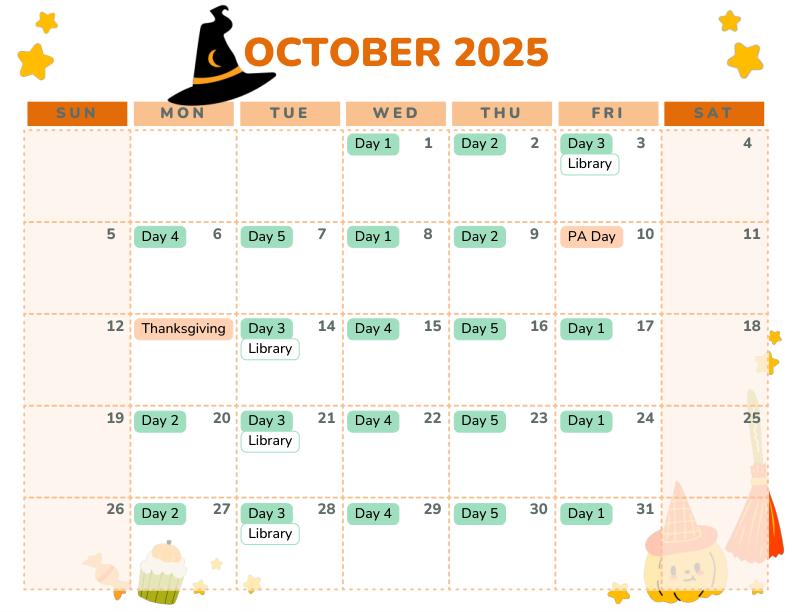

In [ ]:
doc_preview = pymupdf.open(output_pdf)
page = doc_preview[0]
pix = page.get_pixmap()
pil_image = pix.pil_image()
pil_image